In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Lade die numpy-Datei
z_data = np.load(r"C:\Users\knut\Nextcloud\Geotechnik-Freigaben\Dienstleistung\Versuche_FuE\F_05_Schüttkegel_Anton\Kalibrierung_mitMaß\z_20250825_141755.npy")
lumi_data = np.load(r"C:\Users\knut\Nextcloud\Geotechnik-Freigaben\Dienstleistung\Versuche_FuE\F_05_Schüttkegel_Anton\Kalibrierung_mitMaß\lumi_20250825_141755.npy")  

In [28]:
#plt.figure(figsize=(12, 6))
#plt.plot(z_data[:,7200:7400:1])
#plt.legend(labels=range(7420,7450))#
#plt.ylim(21000,32000)
#plt.show()  
z_data_local = z_data[:,7200:7400:1]
x_data = np.linspace(0, len(z_data_local[0]), len(z_data_local[0]))
mask = np.where(z_data_local > 30000, z_data_local, np.nan)
x_in = np.zeros(mask.shape[1])
print(mask.shape)
for i in range(mask.shape[1]):
    nan_mask = np.isnan(mask[:, i])
    non_nan_mask = ~nan_mask
    non_nan_indices = np.where(non_nan_mask)[0]
    x_in[i] = x_data[non_nan_indices[0]]


#plt.plot(mask)
#plt.show()
#plt.show()
#plt.plot(lumi_data[:,6000:8000:200])
#plt.show()

(3200, 200)


IndexError: index 223 is out of bounds for axis 0 with size 200

In [149]:
length = 2713 - 223

In [150]:
scale_length = 125/length

In [151]:
scale_length

0.050200803212851405

In [85]:
z_data[220:230,7440]

diff = z_data[230,7440] - z_data[220,7440]


In [86]:

diff2 = z_data[2710,7441] - z_data[2720,7441]


In [89]:
mean_diff = (diff2 + diff)/2

In [90]:
mean_diff

8689.0

In [92]:
scale_height = 34.82/mean_diff

In [93]:
scale_height

0.004007365634710554

In [94]:
z_data_scaled = z_data * scale_height

(80.0, 130.0)

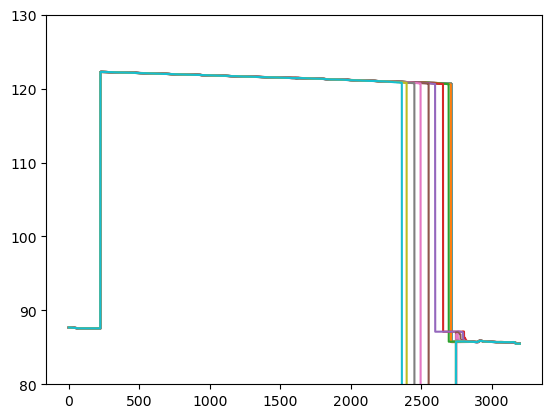

In [99]:
plt.plot(z_data_scaled[:,7440:7460:1])
plt.ylim(80,130)

In [153]:
oben = np.median(z_data[:10,1:13000])
oben

21868.0

In [154]:
unten = np.median(z_data[:-10,1:13000])
unten

21617.0

In [34]:
diff = oben-unten 
diff

251.0

In [36]:
calibrate = np.linspace(0, -diff, 3200)

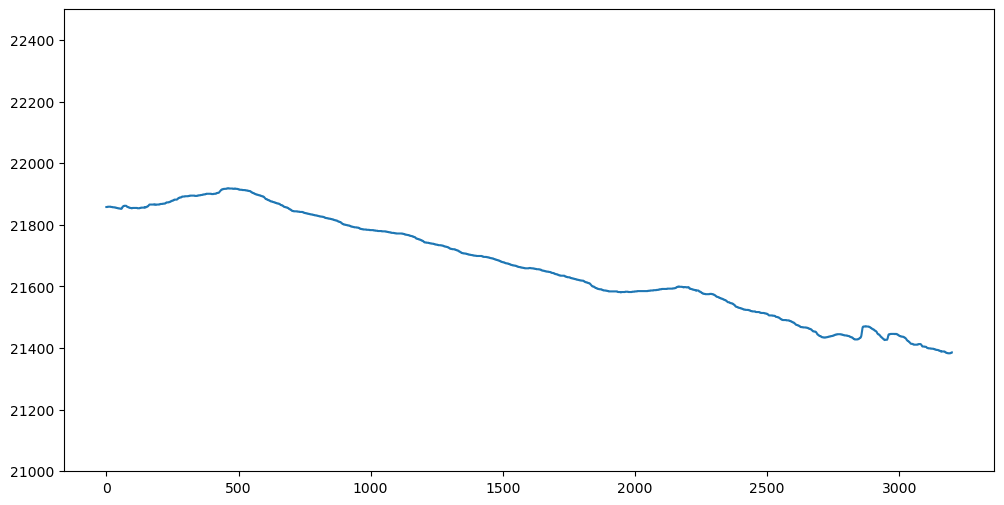

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(z_data[:,1500])
plt.ylim(21000,22500)
plt.show()


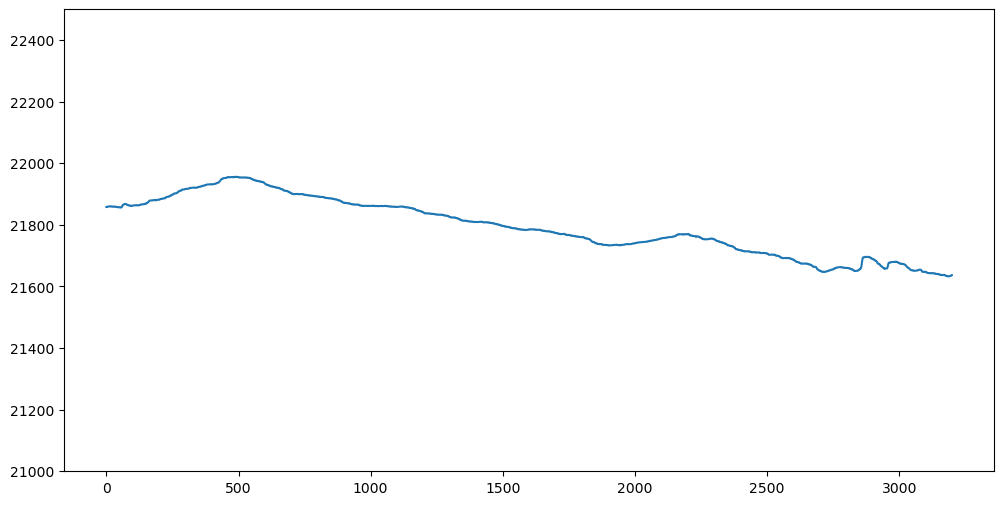

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(z_data[:,1500]-calibrate)
plt.ylim(21000,22500)
plt.show()


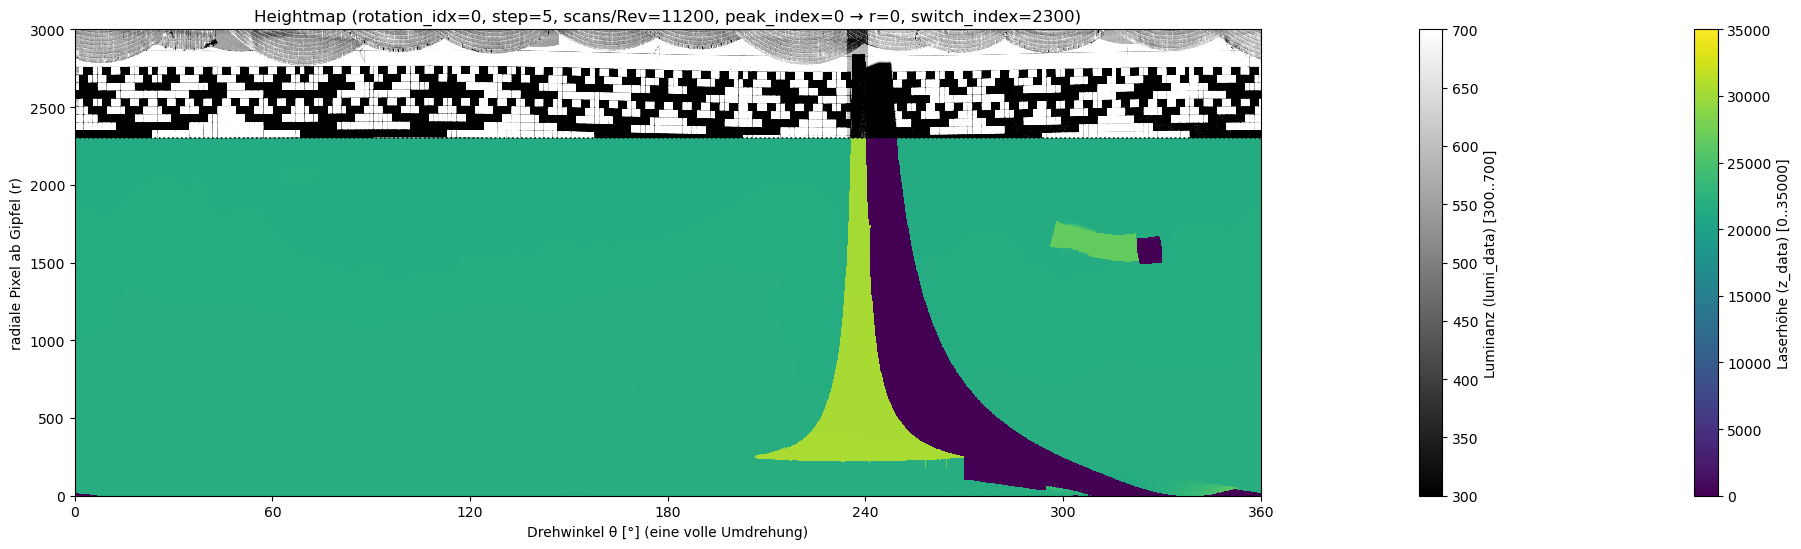

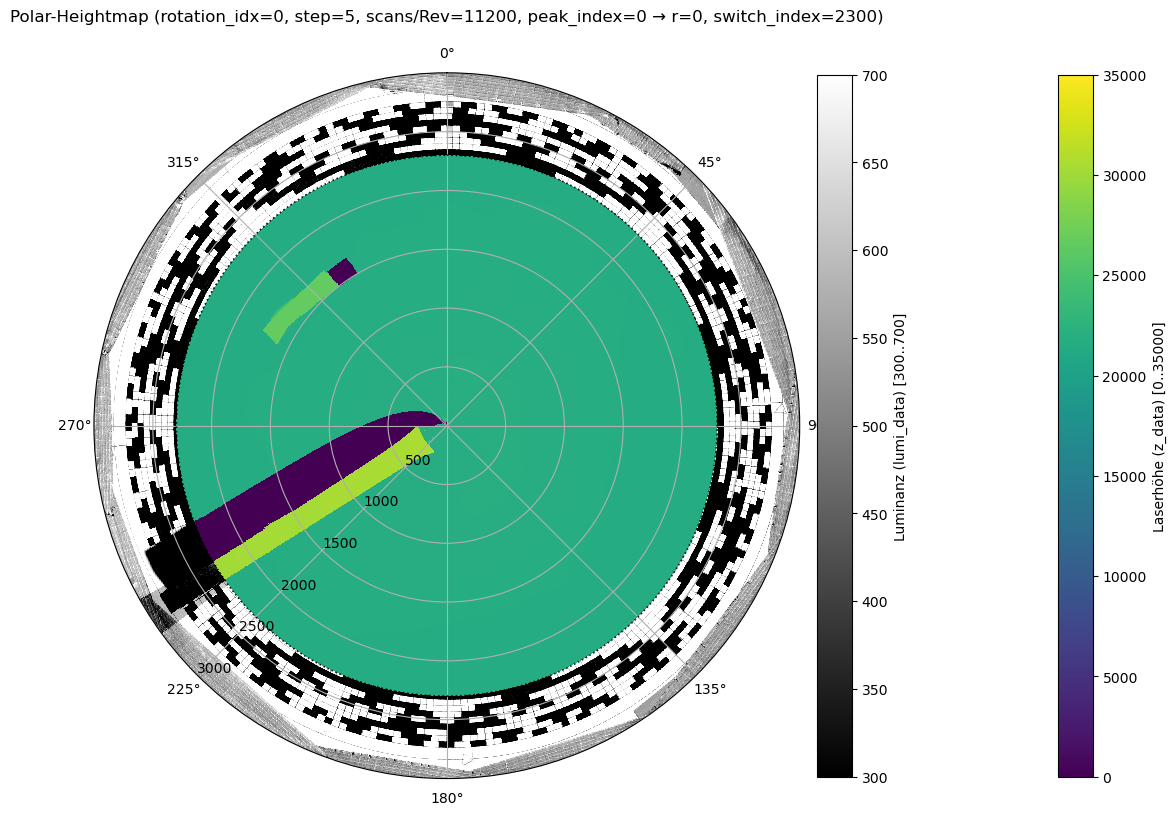

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_heightmap_from_scans_dualscale(
    z_data: np.ndarray,
    lumi_data: np.ndarray,
    peak_index: int = 300,
    scans_per_rev: int = 13_000,
    step: int = 100,
    rotation_idx: int = 0,
    switch_index: int = 2400,         # ab diesem (globalen) Punktindex wird auf Lumi umgeschaltet
    y_window_out: tuple[int, int] | None = None,  # (r_min, r_max) in Pixeln ab peak_index (0..)
    show_colorbars: bool = True,
    # getrennte Skalen:
    z_vmin: float = 20_000, z_vmax: float = 35_000,
    lumi_vmin: float = 0.0, lumi_vmax: float = 1024.0,
    label_z: str = "Laserhöhe (z_data)",
    label_lumi: str = "Luminanz (lumi_data)",
):
    """
    Kartesische Heightmap, NUR ab peak_index nach außen.
    Unterhalb switch_index -> z-Skala [z_vmin, z_vmax],
    ab switch_index        -> lumi-Skala [lumi_vmin, lumi_vmax].
    Separate Colorbars.
    """
    if z_data.ndim != 2 or lumi_data.ndim != 2:
        raise ValueError("z_data und lumi_data müssen 2D sein: (punkte_pro_scan, anzahl_scans)")
    if z_data.shape != lumi_data.shape:
        raise ValueError(f"Shapes unterschiedlich: z_data {z_data.shape} vs lumi_data {lumi_data.shape}")

    n_points, n_scans = z_data.shape
    if not (0 <= peak_index < n_points):
        raise ValueError("peak_index außerhalb des gültigen Bereichs.")
    if not (0 <= switch_index < n_points):
        raise ValueError("switch_index außerhalb des gültigen Bereichs.")

    # Bereich einer vollen Umdrehung
    start = rotation_idx * scans_per_rev
    end   = min(start + scans_per_rev, n_scans)
    if start >= n_scans:
        raise ValueError(f"rotation_idx={rotation_idx} liegt außerhalb (n_scans={n_scans}).")

    # Spalten-Subsampling
    Zz = z_data[:,   start:end:step]
    Zl = lumi_data[:, start:end:step]
    n_used_scans = Zz.shape[1]
    if n_used_scans < 2:
        raise ValueError("Zu wenige Scans nach Subsampling.")

    # NUR ab peak_index (r=0 am peak)
    Zz_out = Zz[peak_index:, :]
    Zl_out = Zl[peak_index:, :]
    Nr_full = Zz_out.shape[0]  # radialer Bereich (Pixel ab peak)

    # switch relativ zu peak
    r_switch = max(0, switch_index - peak_index)

    # Optionaler radialer Ausschnitt (0..)
    r_min = 0 if y_window_out is None else max(0, y_window_out[0])
    r_max = Nr_full - 1 if y_window_out is None else min(Nr_full - 1, y_window_out[1])
    Zz_out = Zz_out[r_min:r_max+1, :]
    Zl_out = Zl_out[r_min:r_max+1, :]
    Nr = Zz_out.shape[0]

    # Masken: Bereich < r_switch -> z, Bereich >= r_switch -> lumi
    Zz_masked = np.ma.array(Zz_out, mask=False)
    Zl_masked = np.ma.array(Zl_out, mask=False)
    if r_switch > 0:
        # Z oberhalb der Umschaltgrenze maskieren
        Zz_masked.mask[min(r_switch - r_min, Nr):, :] = True
    else:
        # Schaltet sofort auf lumi → komplette Zz ausblenden
        Zz_masked.mask[:, :] = True
    # Lumi unterhalb der Umschaltgrenze maskieren
    if r_switch - r_min > 0:
        Zl_masked.mask[:max(0, r_switch - r_min), :] = True

    # x-Achse (0..360°), y-Achse (radial ab peak)
    theta_deg = np.linspace(0.0, 360.0, num=n_used_scans, endpoint=False)
    extent = [theta_deg[0], theta_deg[-1] + (360.0 / n_used_scans), 0, Nr - 1]

    fig, ax = plt.subplots(figsize=(20, 5.6))

    # Z-Teil
    im_z = ax.imshow(
        Zz_masked, origin="lower", aspect="auto", extent=extent,
        vmin=z_vmin, vmax=z_vmax, interpolation="nearest"
    )
    # Lumi-Teil drüber
    im_l = ax.imshow(
        Zl_masked, origin="lower", aspect="auto", extent=extent,
        vmin=lumi_vmin, vmax=lumi_vmax, interpolation="nearest", cmap="gray"
    )

    ax.set_xlabel("Drehwinkel θ [°] (eine volle Umdrehung)")
    ax.set_ylabel("radiale Pixel ab Gipfel (r)")
    ax.set_xticks(np.arange(0, 361, 60))

    # Umschaltlinie bei r_switch (falls sichtbar)
    r_switch_vis = r_switch - r_min
    if 0 <= r_switch_vis <= Nr - 1:
        ax.axhline(r_switch_vis, linestyle=":", linewidth=1.2, color="k", alpha=0.9)

    # Colorbars (z links, lumi rechts)
    if show_colorbars:
        cbar_z = fig.colorbar(im_z, ax=ax, pad=0.02)
        cbar_z.set_label(f"{label_z} [{z_vmin:.0f}..{z_vmax:.0f}]")
        cbar_l = fig.colorbar(im_l, ax=ax, pad=0.10)
        cbar_l.set_label(f"{label_lumi} [{lumi_vmin:.0f}..{lumi_vmax:.0f}]")

    # Legende
    legend_items = [
        Line2D([0], [0], color="k", linestyle=":", lw=1.2, label=f"Umschaltgrenze @ index={switch_index}"),
        Line2D([0], [0], color="none", marker="s", markerfacecolor="none", label=label_z),
        Line2D([0], [0], color="none", marker="o", markerfacecolor="none", label=label_lumi),
    ]
    #ax.legend(handles=legend_items, loc="upper right", frameon=True)

    ax.set_title(
        f"Heightmap (rotation_idx={rotation_idx}, step={step}, scans/Rev={scans_per_rev}, "
        f"peak_index={peak_index} → r=0, switch_index={switch_index})"
    )
    plt.tight_layout()
    plt.show()


def plot_polar_heightmap_from_scans_dualscale(
    z_data: np.ndarray,
    lumi_data: np.ndarray,
    peak_index: int = 300,
    scans_per_rev: int = 13_000,
    step: int = 100,
    rotation_idx: int = 0,
    r_window: tuple[int, int] | None = None,  # (r_min, r_max) ab peak
    theta0_deg: float = 0.0,
    clockwise: bool = True,
    switch_index: int = 2400,
    show_colorbars: bool = True,
    # getrennte Skalen:
    z_vmin: float = 20_000, z_vmax: float = 35_000,
    lumi_vmin: float = 0.0,  lumi_vmax: float = 1024.0,
    label_z: str = "Laserhöhe (z_data)",
    label_lumi: str = "Luminanz (lumi_data)",
):
    """
    Polar-Heatmap, NUR ab peak_index (r=0 am Gipfel).
    Unterhalb switch_index -> z-Skala, ab switch_index -> lumi-Skala.
    """
    if z_data.ndim != 2 or lumi_data.ndim != 2:
        raise ValueError("z_data und lumi_data müssen 2D sein.")
    if z_data.shape != lumi_data.shape:
        raise ValueError(f"Shapes unterschiedlich: z_data {z_data.shape} vs lumi_data {lumi_data.shape}")

    n_points, n_scans = z_data.shape
    if not (0 <= peak_index < n_points):
        raise ValueError("peak_index außerhalb des gültigen Bereichs.")
    if not (0 <= switch_index < n_points):
        raise ValueError("switch_index außerhalb des gültigen Bereichs.")

    # Umdrehungsbereich + Subsampling
    start = rotation_idx * scans_per_rev
    end   = min(start + scans_per_rev, n_scans)
    if start >= n_scans:
        raise ValueError(f"rotation_idx={rotation_idx} liegt außerhalb (n_scans={n_scans}).")
    Zz = z_data[:,   start:end:step]
    Zl = lumi_data[:, start:end:step]
    M  = Zz.shape[1]
    if M < 2:
        raise ValueError("Zu wenige Scans nach Subsampling.")

    # NUR ab peak_index
    Zz_out = Zz[peak_index:, :]
    Zl_out = Zl[peak_index:, :]
    Nr_full = Zz_out.shape[0]

    # switch relativ zu peak
    r_switch = max(0, switch_index - peak_index)

    # Radialer Ausschnitt
    r_min = 0 if r_window is None else max(0, r_window[0])
    r_max = Nr_full - 1 if r_window is None else min(Nr_full - 1, r_window[1])
    Zz_out = Zz_out[r_min:r_max+1, :]
    Zl_out = Zl_out[r_min:r_max+1, :]
    Nr = Zz_out.shape[0]

    # Masken
    Zz_masked = np.ma.array(Zz_out, mask=False)
    Zl_masked = np.ma.array(Zl_out, mask=False)
    if r_switch > 0:
        Zz_masked.mask[min(r_switch - r_min, Nr):, :] = True
    else:
        Zz_masked.mask[:, :] = True
    if r_switch - r_min > 0:
        Zl_masked.mask[:max(0, r_switch - r_min), :] = True

    # Winkelgitter
    theta_centers = np.linspace(np.deg2rad(theta0_deg), np.deg2rad(theta0_deg) + 2*np.pi, num=M, endpoint=False)
    dtheta = 2*np.pi / M
    theta_edges = np.concatenate([theta_centers - dtheta/2, [theta_centers[-1] + dtheta/2]])
    r_edges = np.arange(Nr + 1, dtype=float)

    # Plot
    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection="polar")
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1 if clockwise else 1)

    # z-Teil
    mesh_z = ax.pcolormesh(theta_edges, r_edges, Zz_masked, shading="auto", vmin=z_vmin, vmax=z_vmax)
    # lumi-Teil
    mesh_l = ax.pcolormesh(theta_edges, r_edges, Zl_masked, shading="auto", vmin=lumi_vmin, vmax=lumi_vmax, cmap="gray")

    # Umschaltkreis
    r_switch_vis = r_switch - r_min
    if 0 <= r_switch_vis <= Nr:
        thetas = np.linspace(0, 2*np.pi, 721)
        ax.plot(thetas, np.full_like(thetas, r_switch_vis), linestyle=":", linewidth=1.2, color="k", alpha=0.9)

    ax.set_thetagrids(np.arange(0, 360, 45))
    ax.set_rlabel_position(225)
    ax.set_title(
        f"Polar-Heightmap (rotation_idx={rotation_idx}, step={step}, scans/Rev={scans_per_rev}, "
        f"peak_index={peak_index} → r=0, switch_index={switch_index})",
        pad=18
    )

    if show_colorbars:
        cbar_z = fig.colorbar(mesh_z, ax=ax, pad=0.10, shrink=0.6)
        cbar_z.set_label(f"{label_z} [{z_vmin:.0f}..{z_vmax:.0f}]")
        cbar_l = fig.colorbar(mesh_l, ax=ax, pad=0.02, shrink=0.6)
        cbar_l.set_label(f"{label_lumi} [{lumi_vmin:.0f}..{lumi_vmax:.0f}]")

    # Legende
    legend_items = [
        Line2D([0], [0], color="k", linestyle=":", lw=1.2, label=f"Umschaltgrenze @ index={switch_index}"),
        Line2D([0], [0], color="none", marker="s", markerfacecolor="none", label=label_z),
        Line2D([0], [0], color="none", marker="o", markerfacecolor="none", label=label_lumi),
    ]
    #ax.legend(handles=legend_items, loc="upper right", frameon=True)

    plt.tight_layout()
    plt.show()


plot_heightmap_from_scans_dualscale(
    z_data, lumi_data,
    peak_index=0, scans_per_rev=11_200, step=5, rotation_idx=0,
    switch_index=2300, y_window_out=(0, 3000),
    z_vmin=0, z_vmax=35_000,
    lumi_vmin=300,    lumi_vmax=700
)

plot_polar_heightmap_from_scans_dualscale(
    z_data, lumi_data,
    peak_index=0, scans_per_rev=11_200, step=5, rotation_idx=0,
    switch_index=2300, r_window=(0, 3000),
    z_vmin=0, z_vmax=35_000,
    lumi_vmin=300,    lumi_vmax=700
)

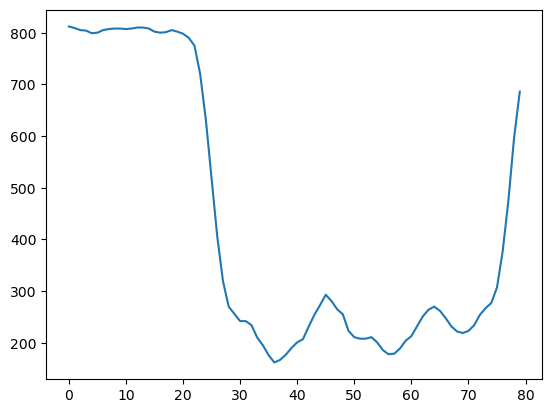

0.04991462720546386

In [176]:
plt.plot(lumi_data[2120:2200,0])
plt.show()

inner_ring = 393
outer_ring = 2150
diff = outer_ring - inner_ring
scale = 87.7/ diff
scale